Upload FinalProject.zip here...


Saving FinalProject.zip to FinalProject.zip
Extracted files: ['.config', 'FinalProject', 'FinalProject.zip', 'sample_data']
Changed directory into FinalProject/
Current directory contents: ['spark-46877704.err', 'pipeline.ipynb', 'tweets_with_topics_v2_flat.csv', 'SPX_full_5min_with_datetime_parts.csv', 'spark-46905470.out', 'standalone (1).sh', 'spark-46905470.err', 'pipeline.py', 'test (1).py', 'spark-46877704.out', 'SecureW2.mobileconfig']
Loaded SPX + Tweet data successfully.
Matched tweets to SPX bars: 11885 events


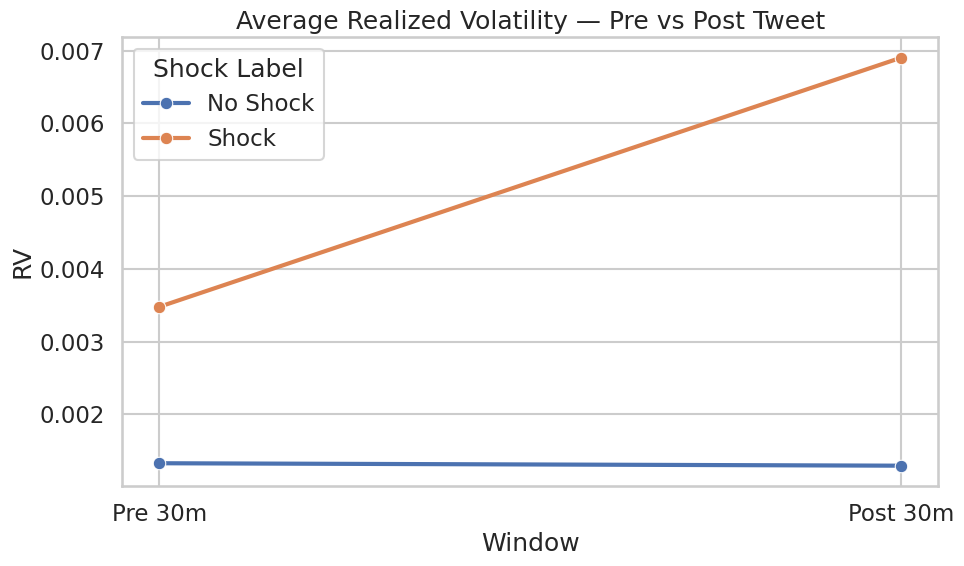

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



===== MODEL RESULTS =====
Accuracy: 0.899
F1 Score: 0.011
ROC-AUC:  0.617
PR-AUC:   0.155


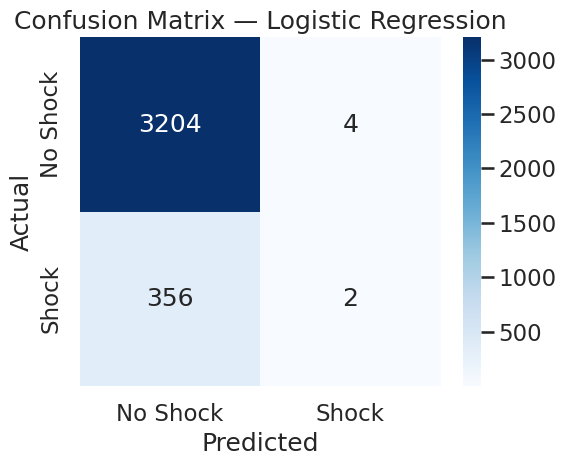

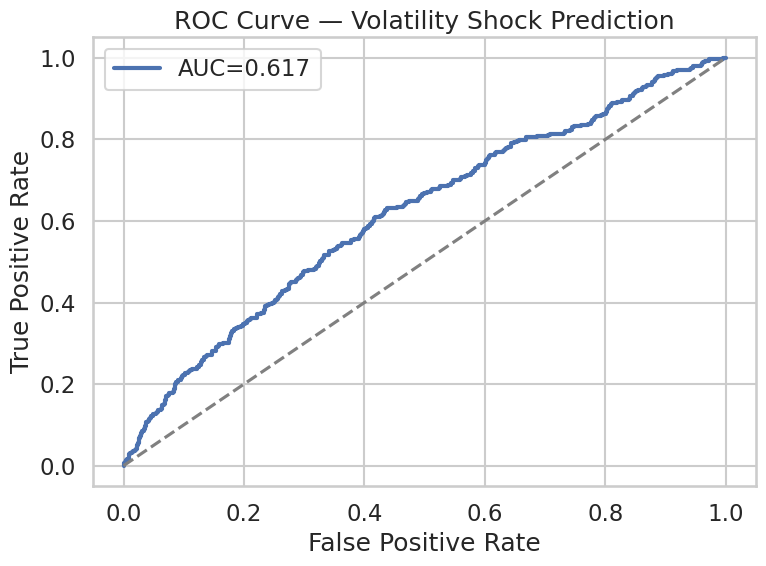

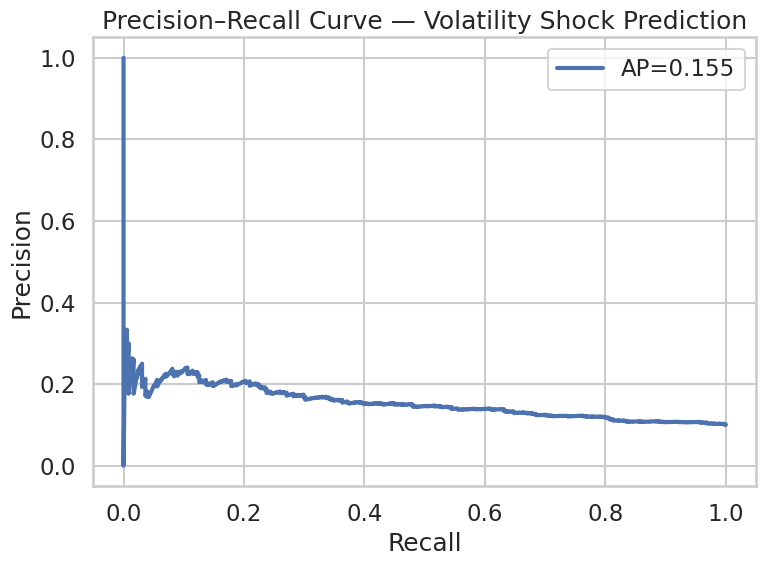


All PNG visualizations saved in: FinalProject/visualizations/


In [1]:
# ================================================================
#  FINAL PROJECT VISUALIZATION PIPELINE — GOOGLE COLAB VERSION
#  Clean, Presentation-Ready Visuals (NO SPARK)
# ================================================================

!pip install -q pandas numpy scikit-learn matplotlib seaborn

import zipfile, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)

# -------------------------------------------------------------
# 1. UPLOAD ZIP (FinalProject.zip)
# -------------------------------------------------------------
print("Upload FinalProject.zip here...")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# Extract zip to current directory
with zipfile.ZipFile(zip_name, "r") as z:
    z.extractall()

print("Extracted files:", os.listdir())

# -------------------------------------------------------------
# 2. CHANGE INTO FinalProject FOLDER
# -------------------------------------------------------------
if "FinalProject" in os.listdir():
    os.chdir("FinalProject")
    print("Changed directory into FinalProject/")
else:
    raise RuntimeError("ERROR: Folder 'FinalProject' not found in zip extraction")

print("Current directory contents:", os.listdir())

# -------------------------------------------------------------
# 3. LOAD DATA FILES
# -------------------------------------------------------------
spx = pd.read_csv("SPX_full_5min_with_datetime_parts.csv")
tweets = pd.read_csv("tweets_with_topics_v2_flat.csv")

print("Loaded SPX + Tweet data successfully.")

# -------------------------------------------------------------
# 4. BUILD TWEET FEATURES (timestamps + text-based features)
# -------------------------------------------------------------
tweets["tweet_time"] = pd.to_datetime({
    "year": tweets.year,
    "month": tweets.month,
    "day": tweets.day,
    "hour": tweets.hour,
    "minute": tweets.minute,
    "second": tweets.second
})

# Extra features from the text
tweets["text_length"] = tweets["text"].astype(str).str.len()
tweets["exclamation_count"] = tweets["text"].astype(str).str.count("!")

# -------------------------------------------------------------
# 5. BUILD SPX TIMESTAMPS + 30m REALIZED VOLATILITY
# -------------------------------------------------------------
spx["bar_time"] = pd.to_datetime({
    "year": spx.year,
    "month": spx.month,
    "day": spx.day,
    "hour": spx.hour,
    "minute": spx.minute,
    "second": spx.second
})

spx["log_return"] = np.log(spx["Close"] / spx["Close"].shift(1))

# 6 bars of 5-minute data = 30 minutes
spx["rv_pre_30m"] = spx["log_return"].rolling(6).apply(
    lambda x: np.sqrt(np.sum(x**2)), raw=True
)
spx["rv_post_30m"] = spx["log_return"].shift(-6).rolling(6).apply(
    lambda x: np.sqrt(np.sum(x**2)), raw=True
)

# -------------------------------------------------------------
# 6. MATCH TWEETS TO NEAREST SPX BAR (± 10 min)
# -------------------------------------------------------------
merged = tweets.merge(spx, on=["year", "month", "day"])

merged["time_diff_sec"] = (merged["bar_time"] - merged["tweet_time"]).abs().dt.total_seconds()

events = (
    merged[merged["time_diff_sec"] <= 600]   # ±10 minutes
    .sort_values(["id", "time_diff_sec"])
    .groupby("id")
    .head(1)
)

print(f"Matched tweets to SPX bars: {events.shape[0]} events")

# -------------------------------------------------------------
# 7. LABEL SHOCKS (top 10% of post-tweet realized volatility)
# -------------------------------------------------------------
threshold = events["rv_post_30m"].quantile(0.90)
events["is_shock"] = (events["rv_post_30m"] > threshold).astype(int)

# -------------------------------------------------------------
# 8. SETUP VISUALIZATION STYLE + FOLDER
# -------------------------------------------------------------
os.makedirs("visualizations", exist_ok=True)
sns.set_theme(style="whitegrid", context="talk")

# -------------------------------------------------------------
# 9. VOLATILITY EVENT PLOT (PRETTY)
# -------------------------------------------------------------
avg_pre = events.groupby("is_shock")["rv_pre_30m"].mean()
avg_post = events.groupby("is_shock")["rv_post_30m"].mean()

vol_df = pd.DataFrame({
    "Shock Label": ["No Shock", "Shock"],
    "Pre 30m": avg_pre.values,
    "Post 30m": avg_post.values
})

vol_long = vol_df.melt(
    id_vars="Shock Label",
    var_name="Window",
    value_name="RV"
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=vol_long,
    x="Window",
    y="RV",
    hue="Shock Label",
    marker="o",
    linewidth=3
)
plt.title("Average Realized Volatility — Pre vs Post Tweet")
plt.tight_layout()
plt.savefig("visualizations/volatility_event_plot.png", dpi=300)
plt.show()

# -------------------------------------------------------------
# 10. MACHINE LEARNING PREP
# -------------------------------------------------------------
cat_cols = ["category", "blue_category", "sentiment", "intensity"]

num_cols = [
    "rv_pre_30m",
    "Close",
    "favorites",
    "retweets",
    "text_length",
    "exclamation_count"
]

# Fill missing values
events[num_cols] = events[num_cols].fillna(0)
events[cat_cols] = events[cat_cols].fillna("Unknown")

# One-hot encode categoricals
df_ml = pd.get_dummies(events[["is_shock"] + cat_cols + num_cols], drop_first=True)

X = df_ml.drop(columns=["is_shock"])
y = df_ml["is_shock"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# -------------------------------------------------------------
# 11. TRAIN LOGISTIC REGRESSION
# -------------------------------------------------------------
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print("\n===== MODEL RESULTS =====")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC:  {roc_auc:.3f}")
print(f"PR-AUC:   {pr_auc:.3f}")

# -------------------------------------------------------------
# 12. CONFUSION MATRIX (PRETTY)
# -------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Shock", "Shock"],
    yticklabels=["No Shock", "Shock"]
)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("visualizations/confusion_matrix.png", dpi=300)
plt.show()

# -------------------------------------------------------------
# 13. ROC CURVE (PRETTY)
# -------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=3, label=f"AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Volatility Shock Prediction")
plt.legend()
plt.tight_layout()
plt.savefig("visualizations/roc_curve.png", dpi=300)
plt.show()

# -------------------------------------------------------------
# 14. PRECISION–RECALL CURVE (PRETTY)
# -------------------------------------------------------------
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=3, label=f"AP={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Volatility Shock Prediction")
plt.legend()
plt.tight_layout()
plt.savefig("visualizations/pr_curve.png", dpi=300)
plt.show()

print("\nAll PNG visualizations saved in: FinalProject/visualizations/")
